In [1]:
from typing import List

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm 

from serimats.paths.experiment import *

In [ ]:
def random_hyperwalk(n_dims: int, n_samples: int = 1_000, n_timesteps: int = 10_000) -> np.ndarray:
    state = np.zeros((n_samples, n_dims))
    distances = np.zeros((n_samples, n_timesteps))

    for t in tqdm(range(n_timesteps)):
        step = np.random.choice(np.arange(n_dims), n_samples)
        # print(step)
        directions = np.random.choice([-1, 1], n_samples)
        # print(directions)

        # TODO: vectorize this
        for i in range(n_samples):
            state[i, step[i]] += directions[i]

        # print(step, directions, state[:, step])
        distances[:, t] = np.linalg.norm(state, axis=1)

    return distances

def random_hyperwalk_scaling(n_dim_range: List[int], n_samples: int = 1_000, n_timesteps: int = 10_000):
    timesteps = np.arange(n_timesteps)
    predictions = np.sqrt(timesteps)
    trajectories = np.zeros((len(n_dim_range), n_samples, n_timesteps))

    fig, ax = plt.subplots(len(n_dim_range) // 2, 2, figsize=(10, 10))
    fig.tight_layout(pad=5.0)

    for I, n_dims in enumerate(n_dim_range):
        i, j = I // 2, I % 2

        trajectories[I, :, :] = random_hyperwalk(n_dims, n_samples, n_timesteps)
        mean_distances = np.mean(trajectories[I, :, :], axis=0)

        for k in range(n_samples):
            ax[i][j].plot(timesteps, trajectories[I, k, :], color="blue", alpha=0.01)
    
        ax[i][j].set_title(f"{n_dims} dimensions")
        ax[i][j].plot(timesteps, mean_distances, color="red")
        ax[i][j].plot(timesteps, predictions, color="black")
        ax[i][j].set_xlabel("Timesteps")
        ax[i][j].set_ylabel("L2 distance from origin")

    plt.show()


random_hyperwalk_scaling([5, 10, 20, 40, 80, 160], n_samples=1000, n_timesteps=1000)

In [ ]:
def n_params(n_hidden: int, width: int, n_in = 784, n_out = 10) -> int:
    """Returns the number of parameters in a feedforward neural network"""
    return (n_in + 1) * width + (n_hidden) * (width + 1) * width + (width + 1) * n_out 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot a mixture of Gaussians
axes[0].set_title("$p(D_n|w)$")
axes[1].set_title(r"$-\log p(D_n|w)$")

x = np.linspace(-5, 5, 1000)
y = 0.9 * np.exp(-x**2 / 2) / np.sqrt(2 * np.pi) + 0.3 * np.exp(-(x - 2)**2 / 2) / np.sqrt(2 * np.pi) +  0.1 * np.exp(-(x + 1)**2 / 2) / np.sqrt(2 * np.pi)

axes[0].plot(x, y)
axes[1].plot(x, -np.log(y))

# Plot a Gaussian distribution

x = np.linspace(-5, 5, 1000)
y = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
axes[0].plot(x, y)
axes[1].plot(x, -np.log(y))

fig.tight_layout(pad=-3.0)

for ax in axes:
    ax.axis("off")
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

# Resolution
dpi = 300
fig.set_size_inches(1920 / dpi, 720 / dpi)
fig.set_dpi(dpi)

# Transparent background
fig.patch.set_alpha(0.0)

plt.show()

In [2]:
ensembles = [ensemble for ensemble in make_ensembles(experiments)] 

RuntimeError: generator raised StopIteration

0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


/Users/Jesse/.virtualenvs/notes/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/.virtualenvs/notes/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training...:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: 0it [00:00, ?it/s]

Testing 0: 0it [00:00, ?it/s]

/Users/Jesse/Projects/notes/serimats/paths/plots.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = averages.groupby([comparison, "step"]).mean()
/Users/Jesse/Projects/notes/serimats/paths/plots.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = averages.groupby([comparison, "step"]).mean()
/Users/Jesse/Projects/notes/serimats/paths/plots.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a

KeyboardInterrupt: 

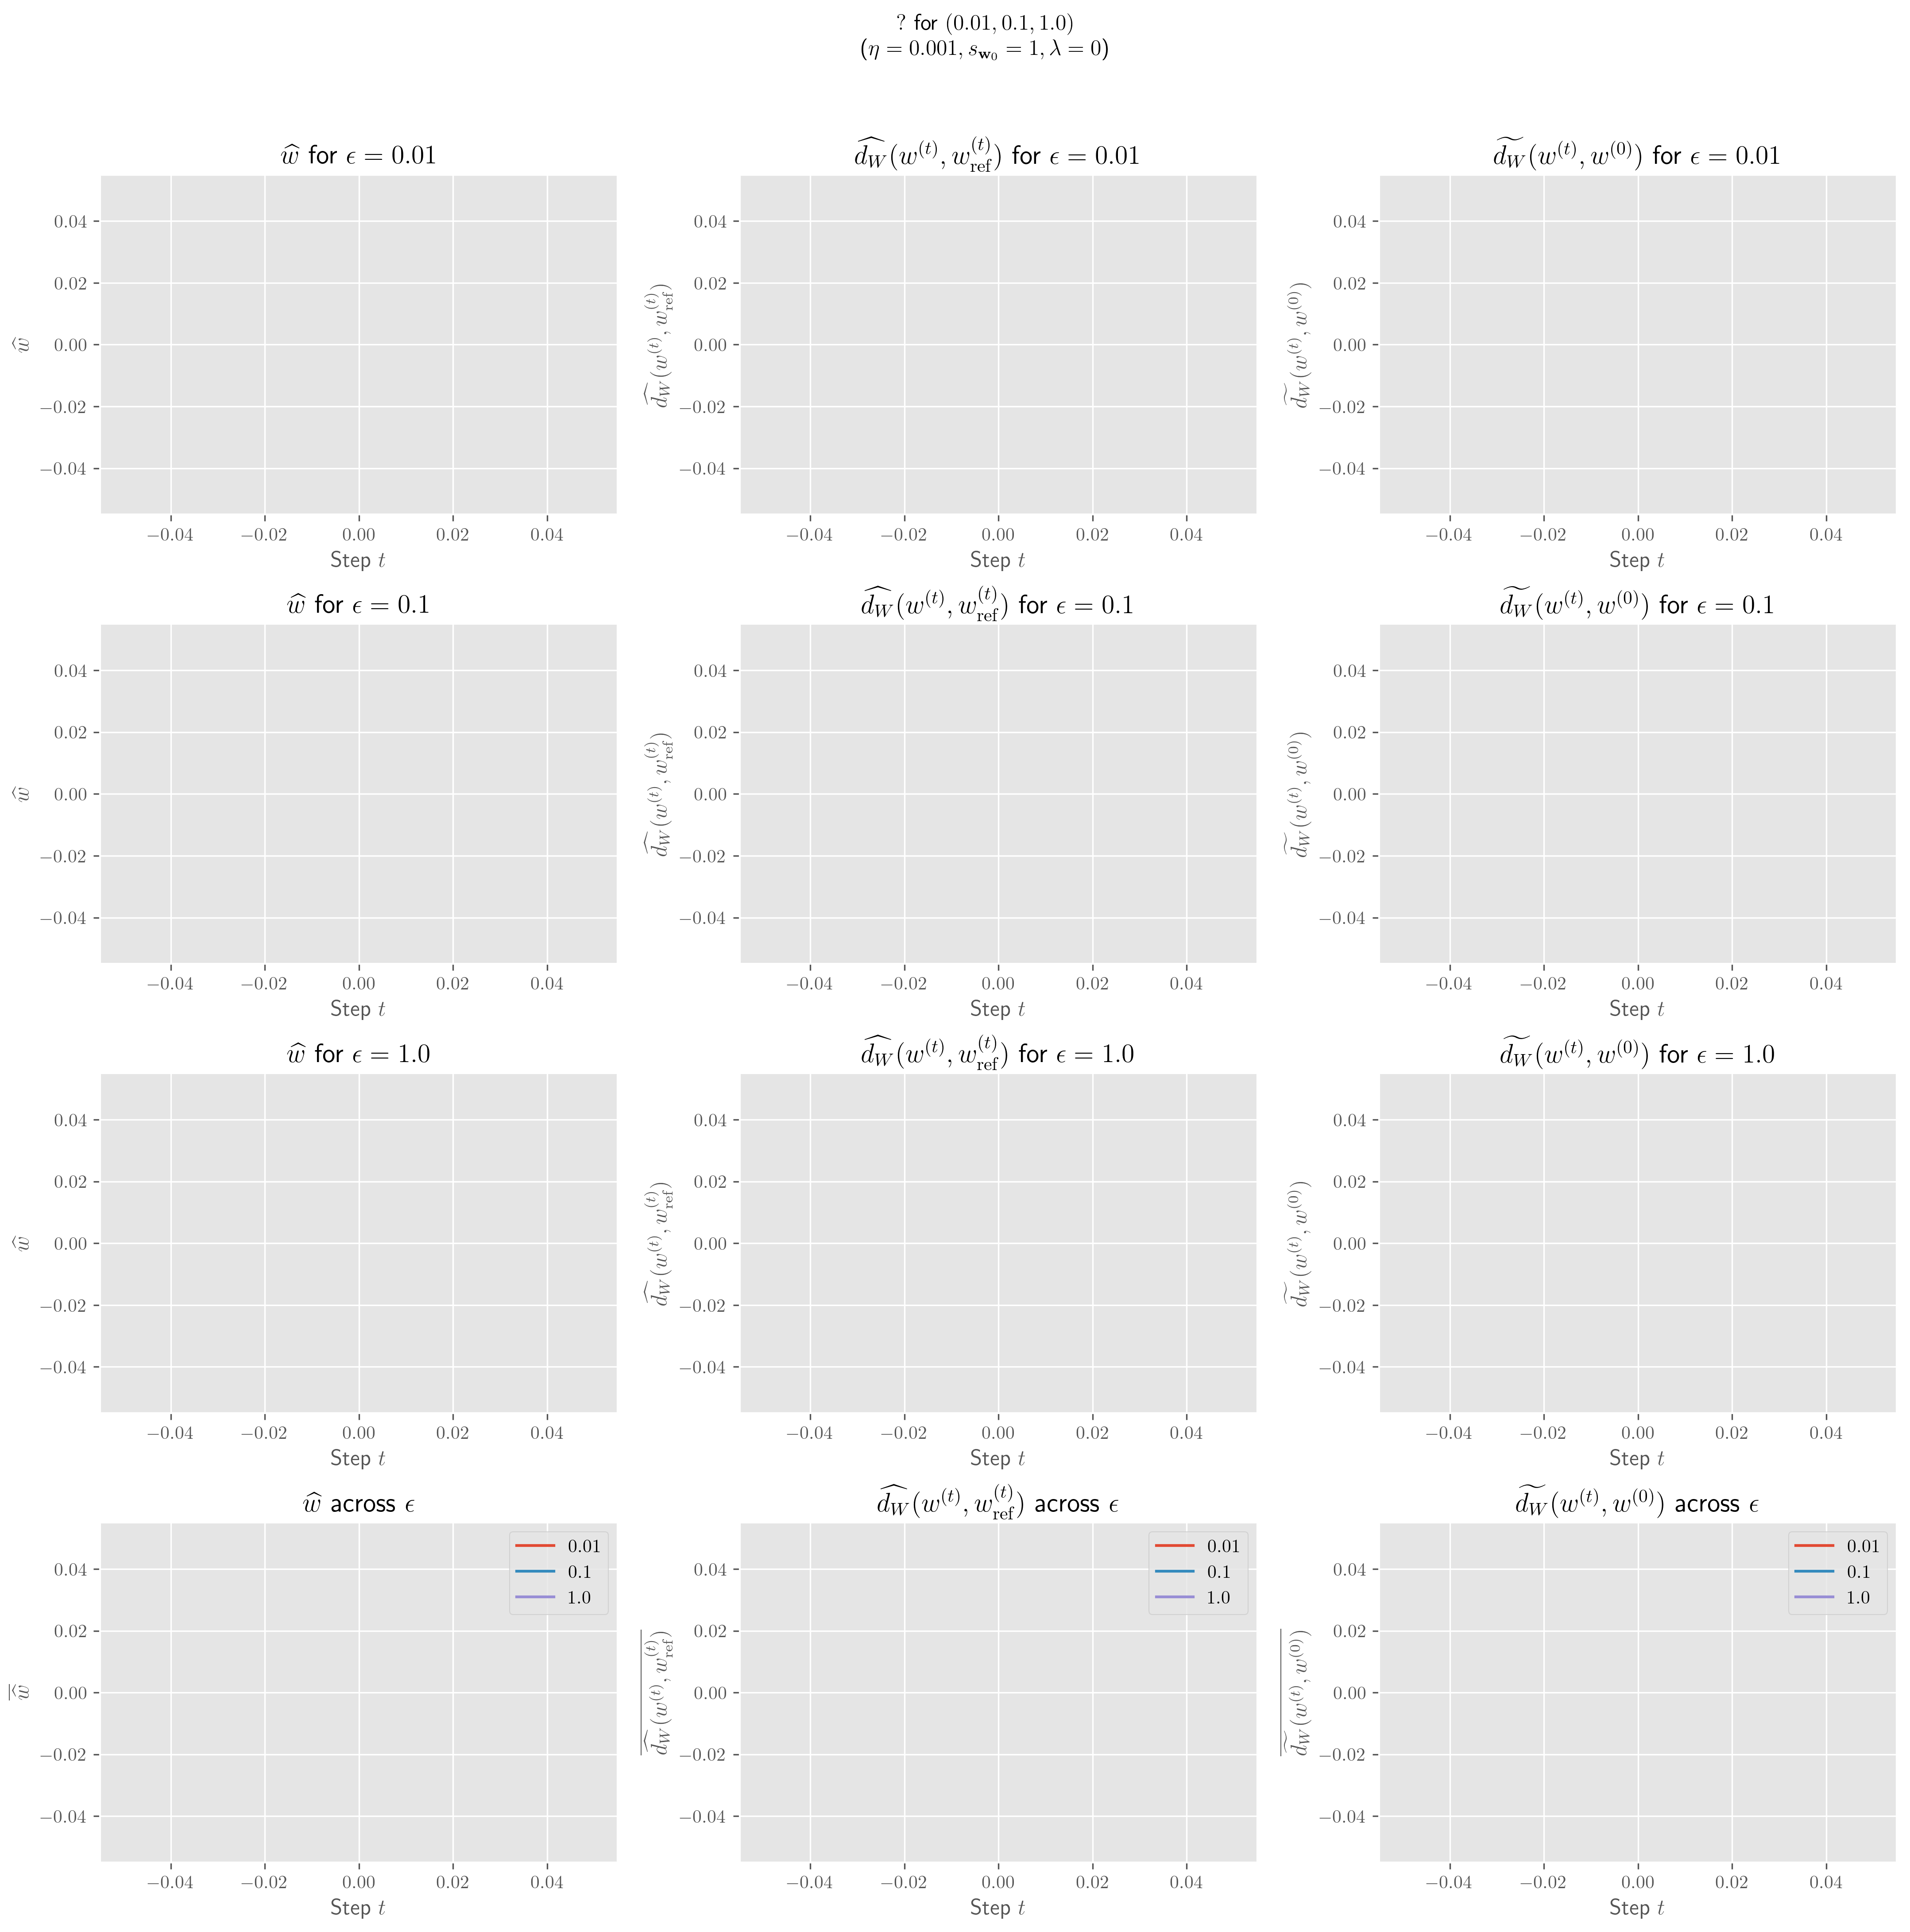

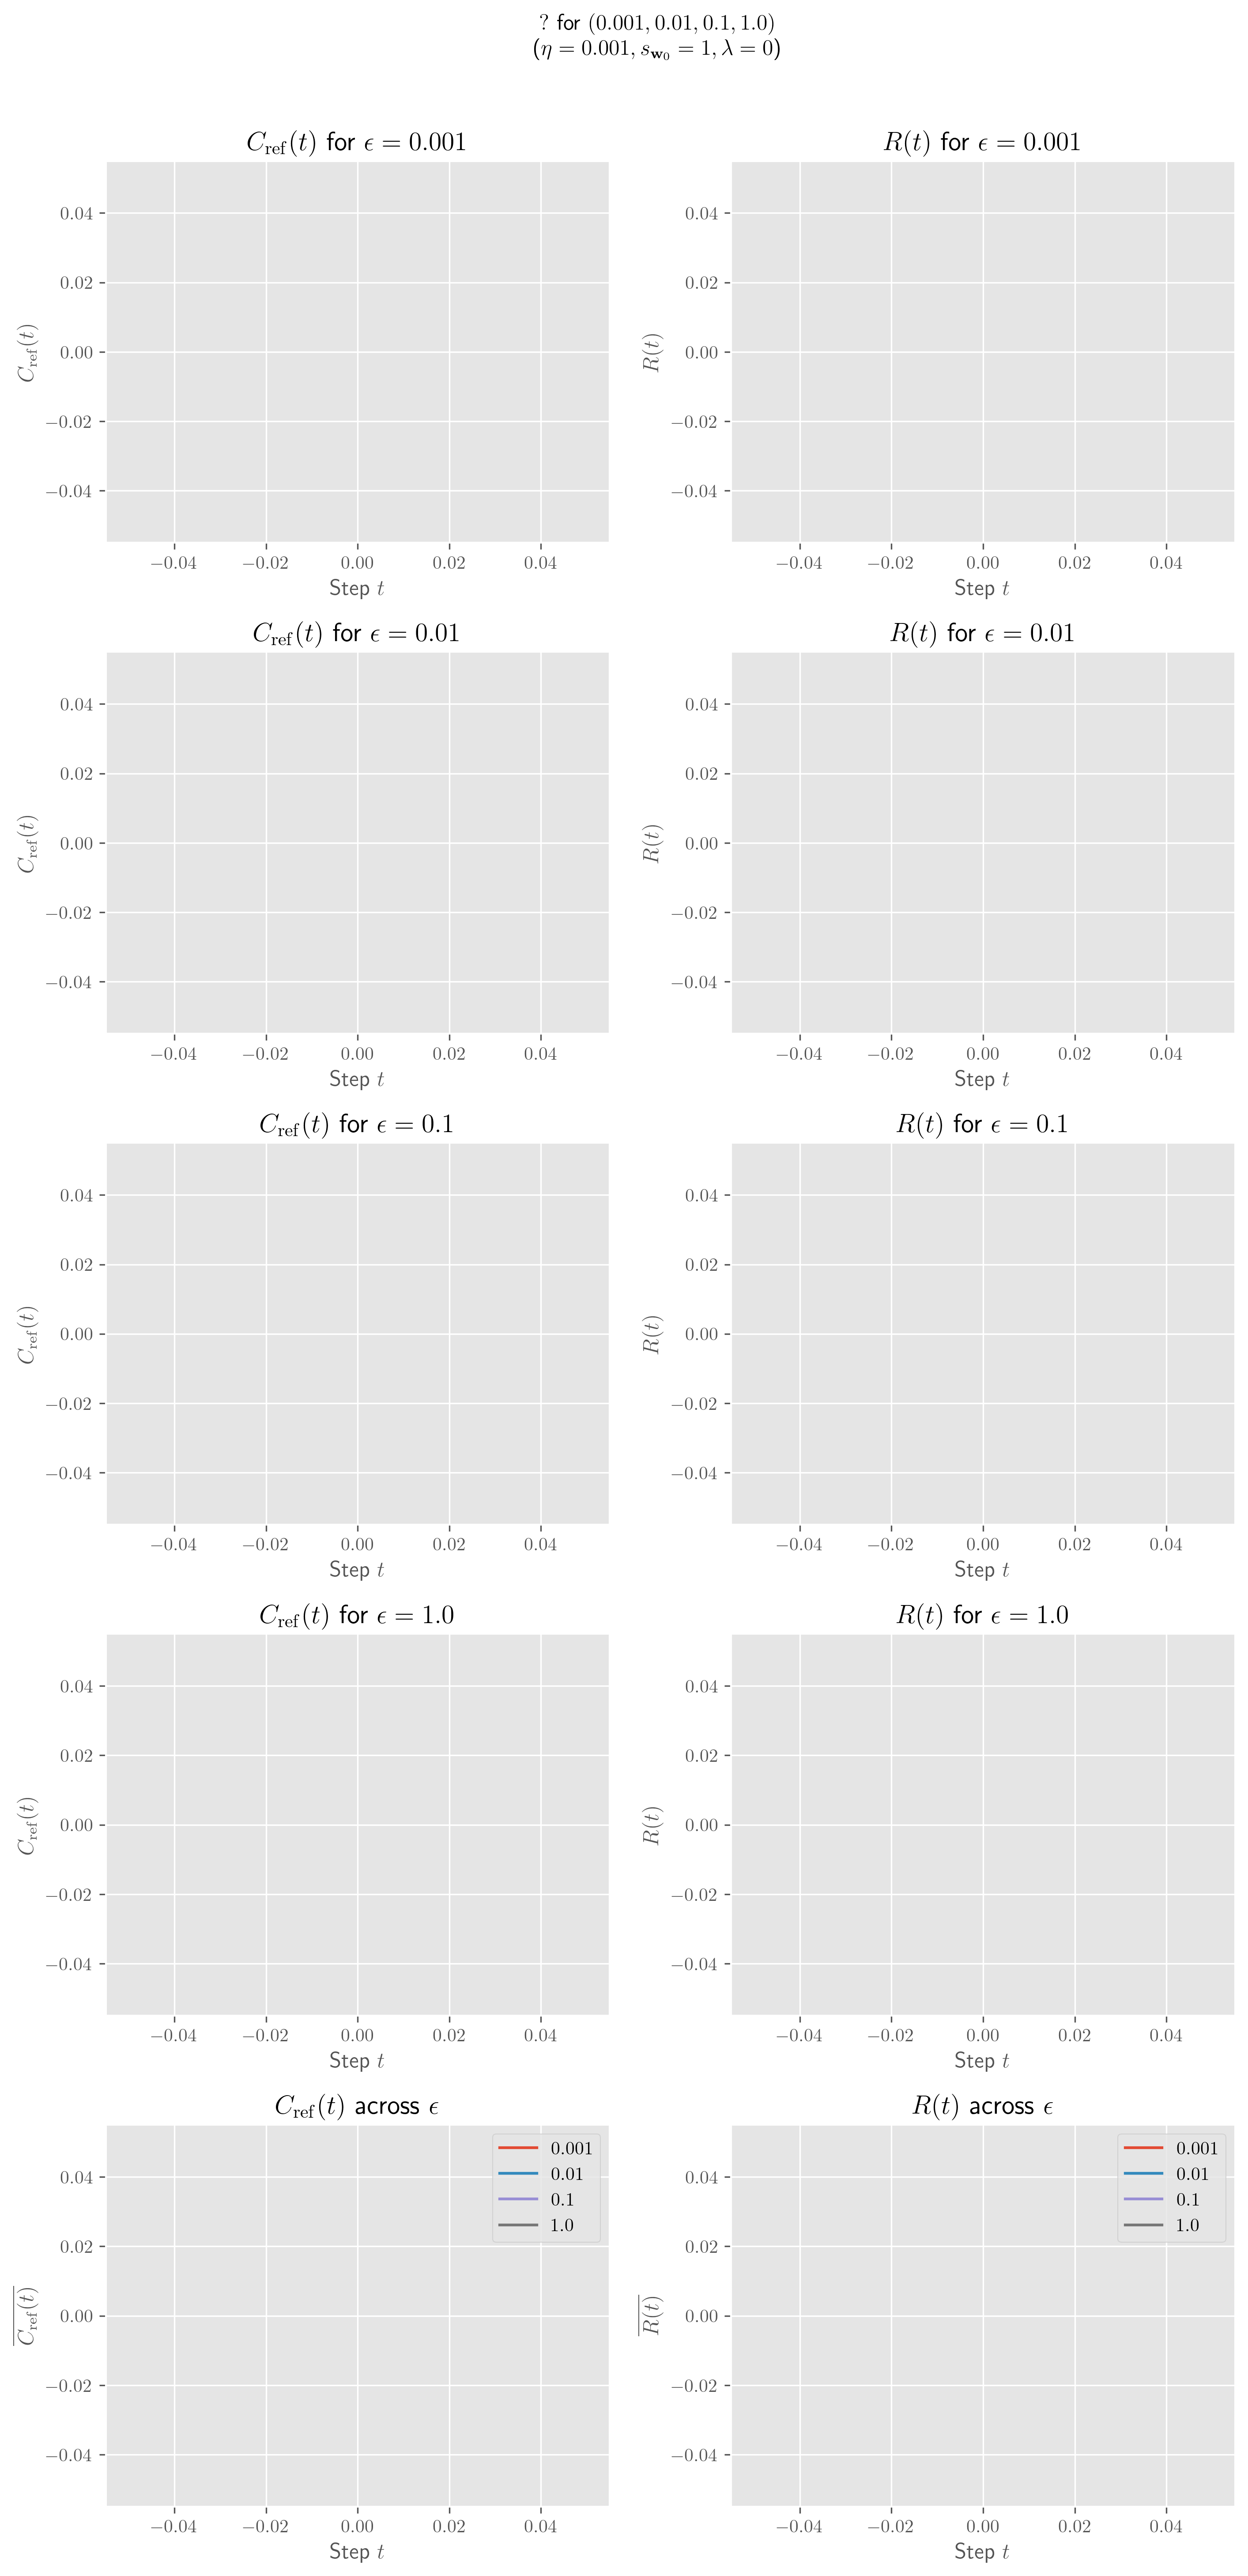

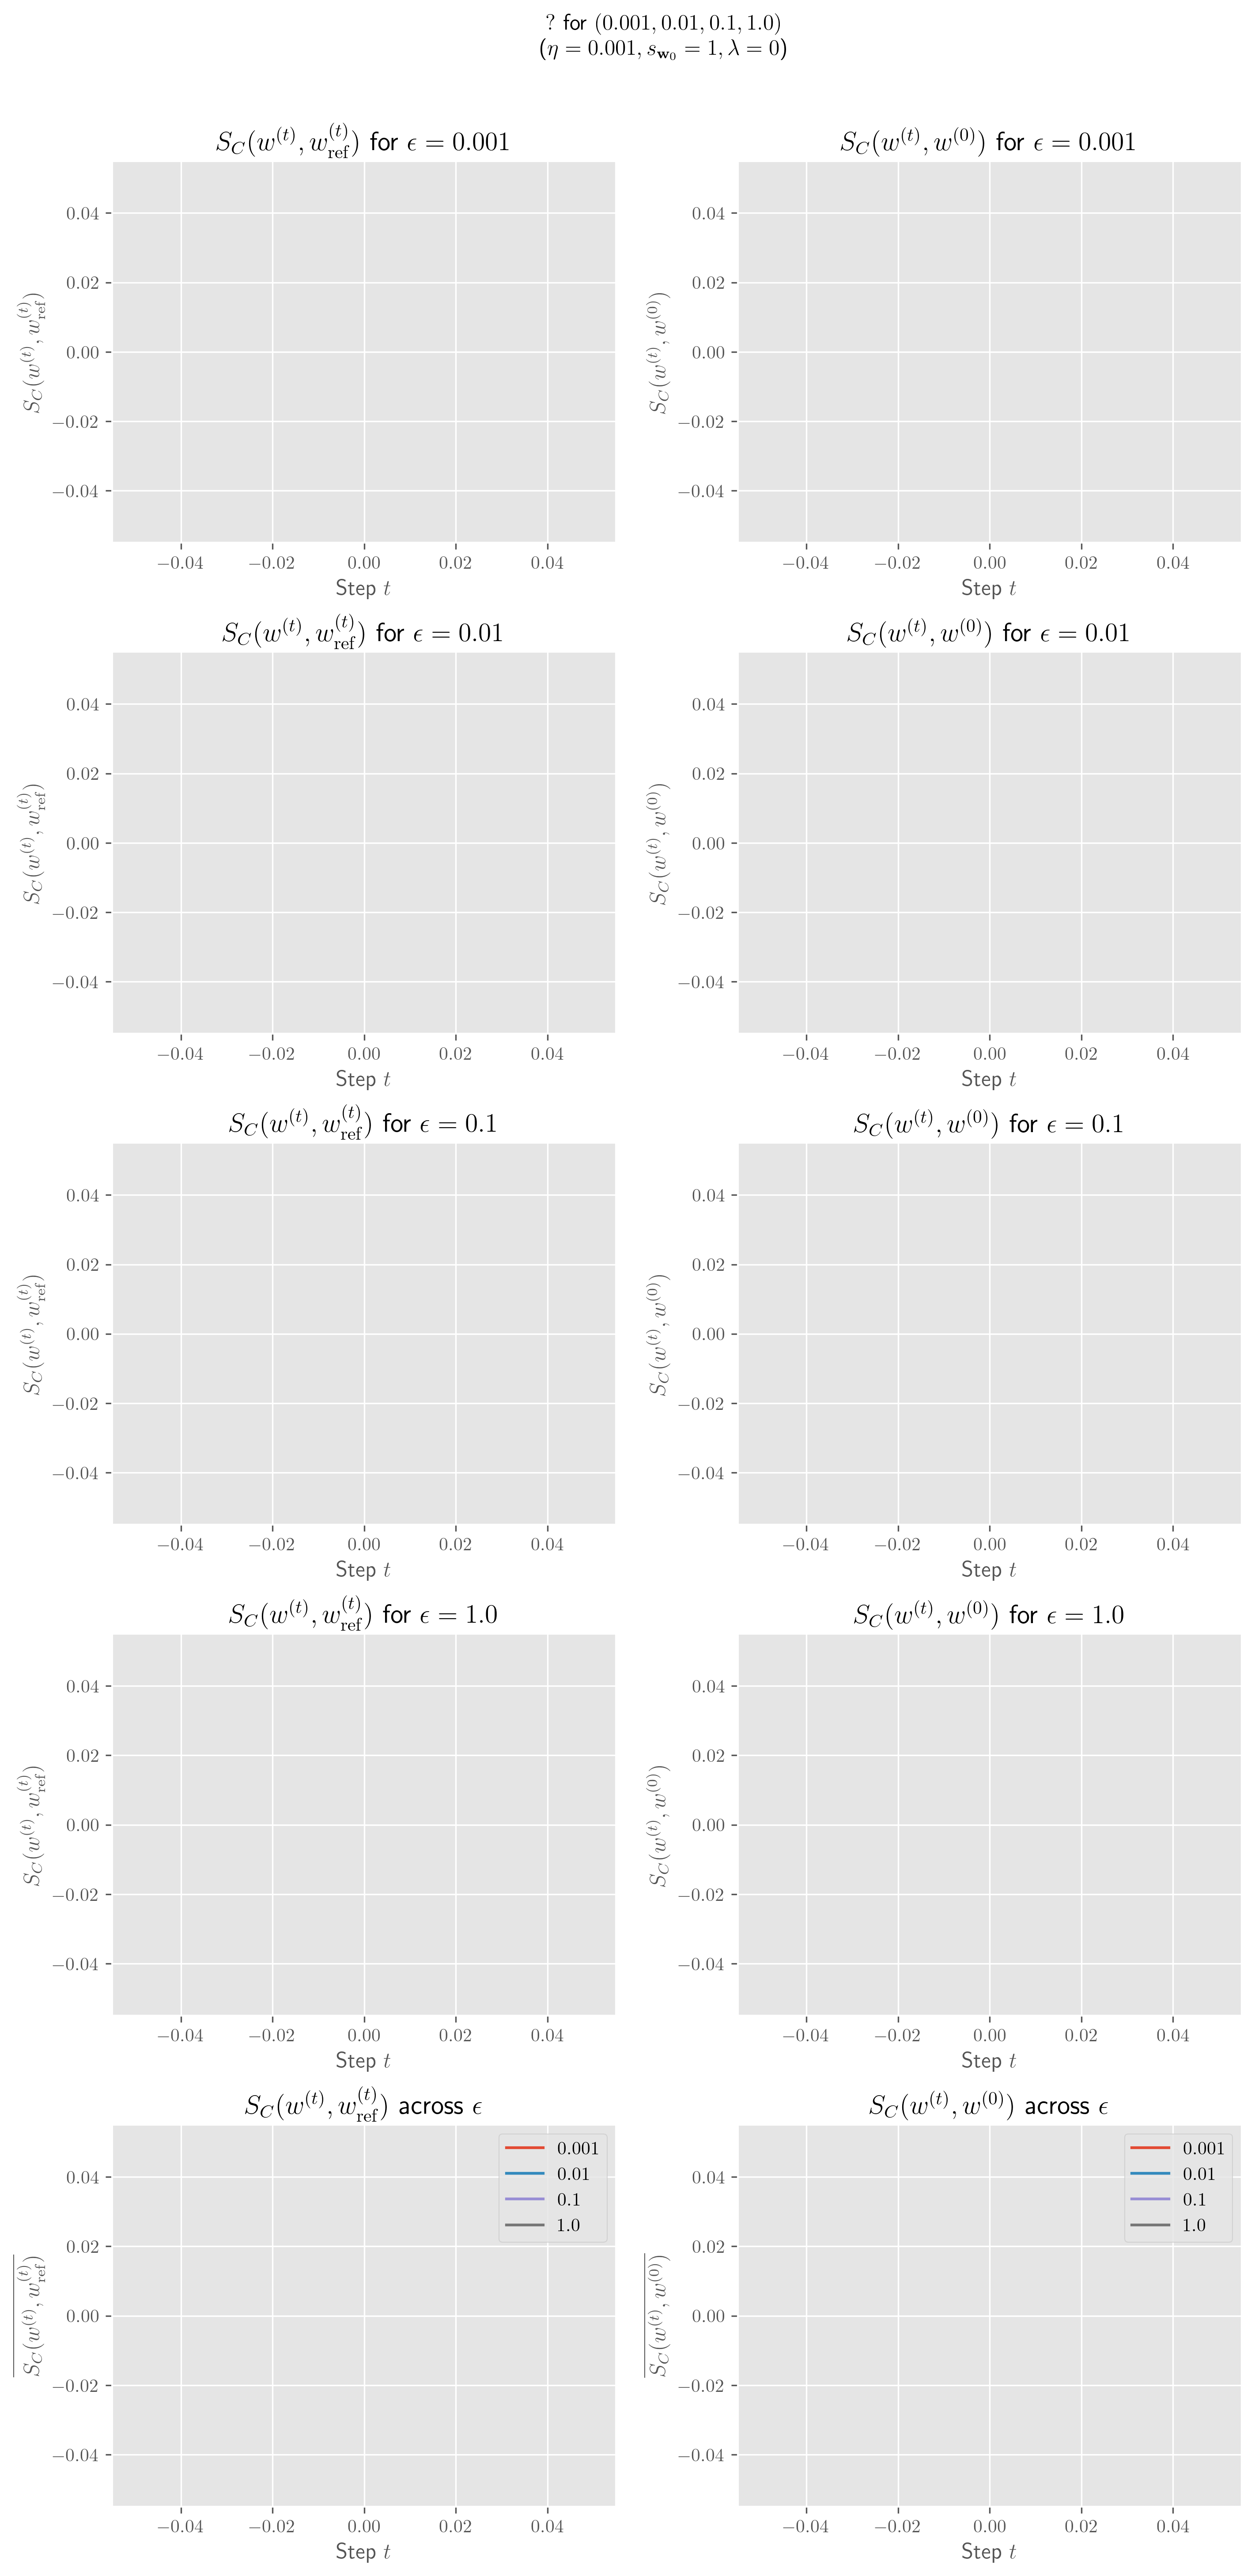

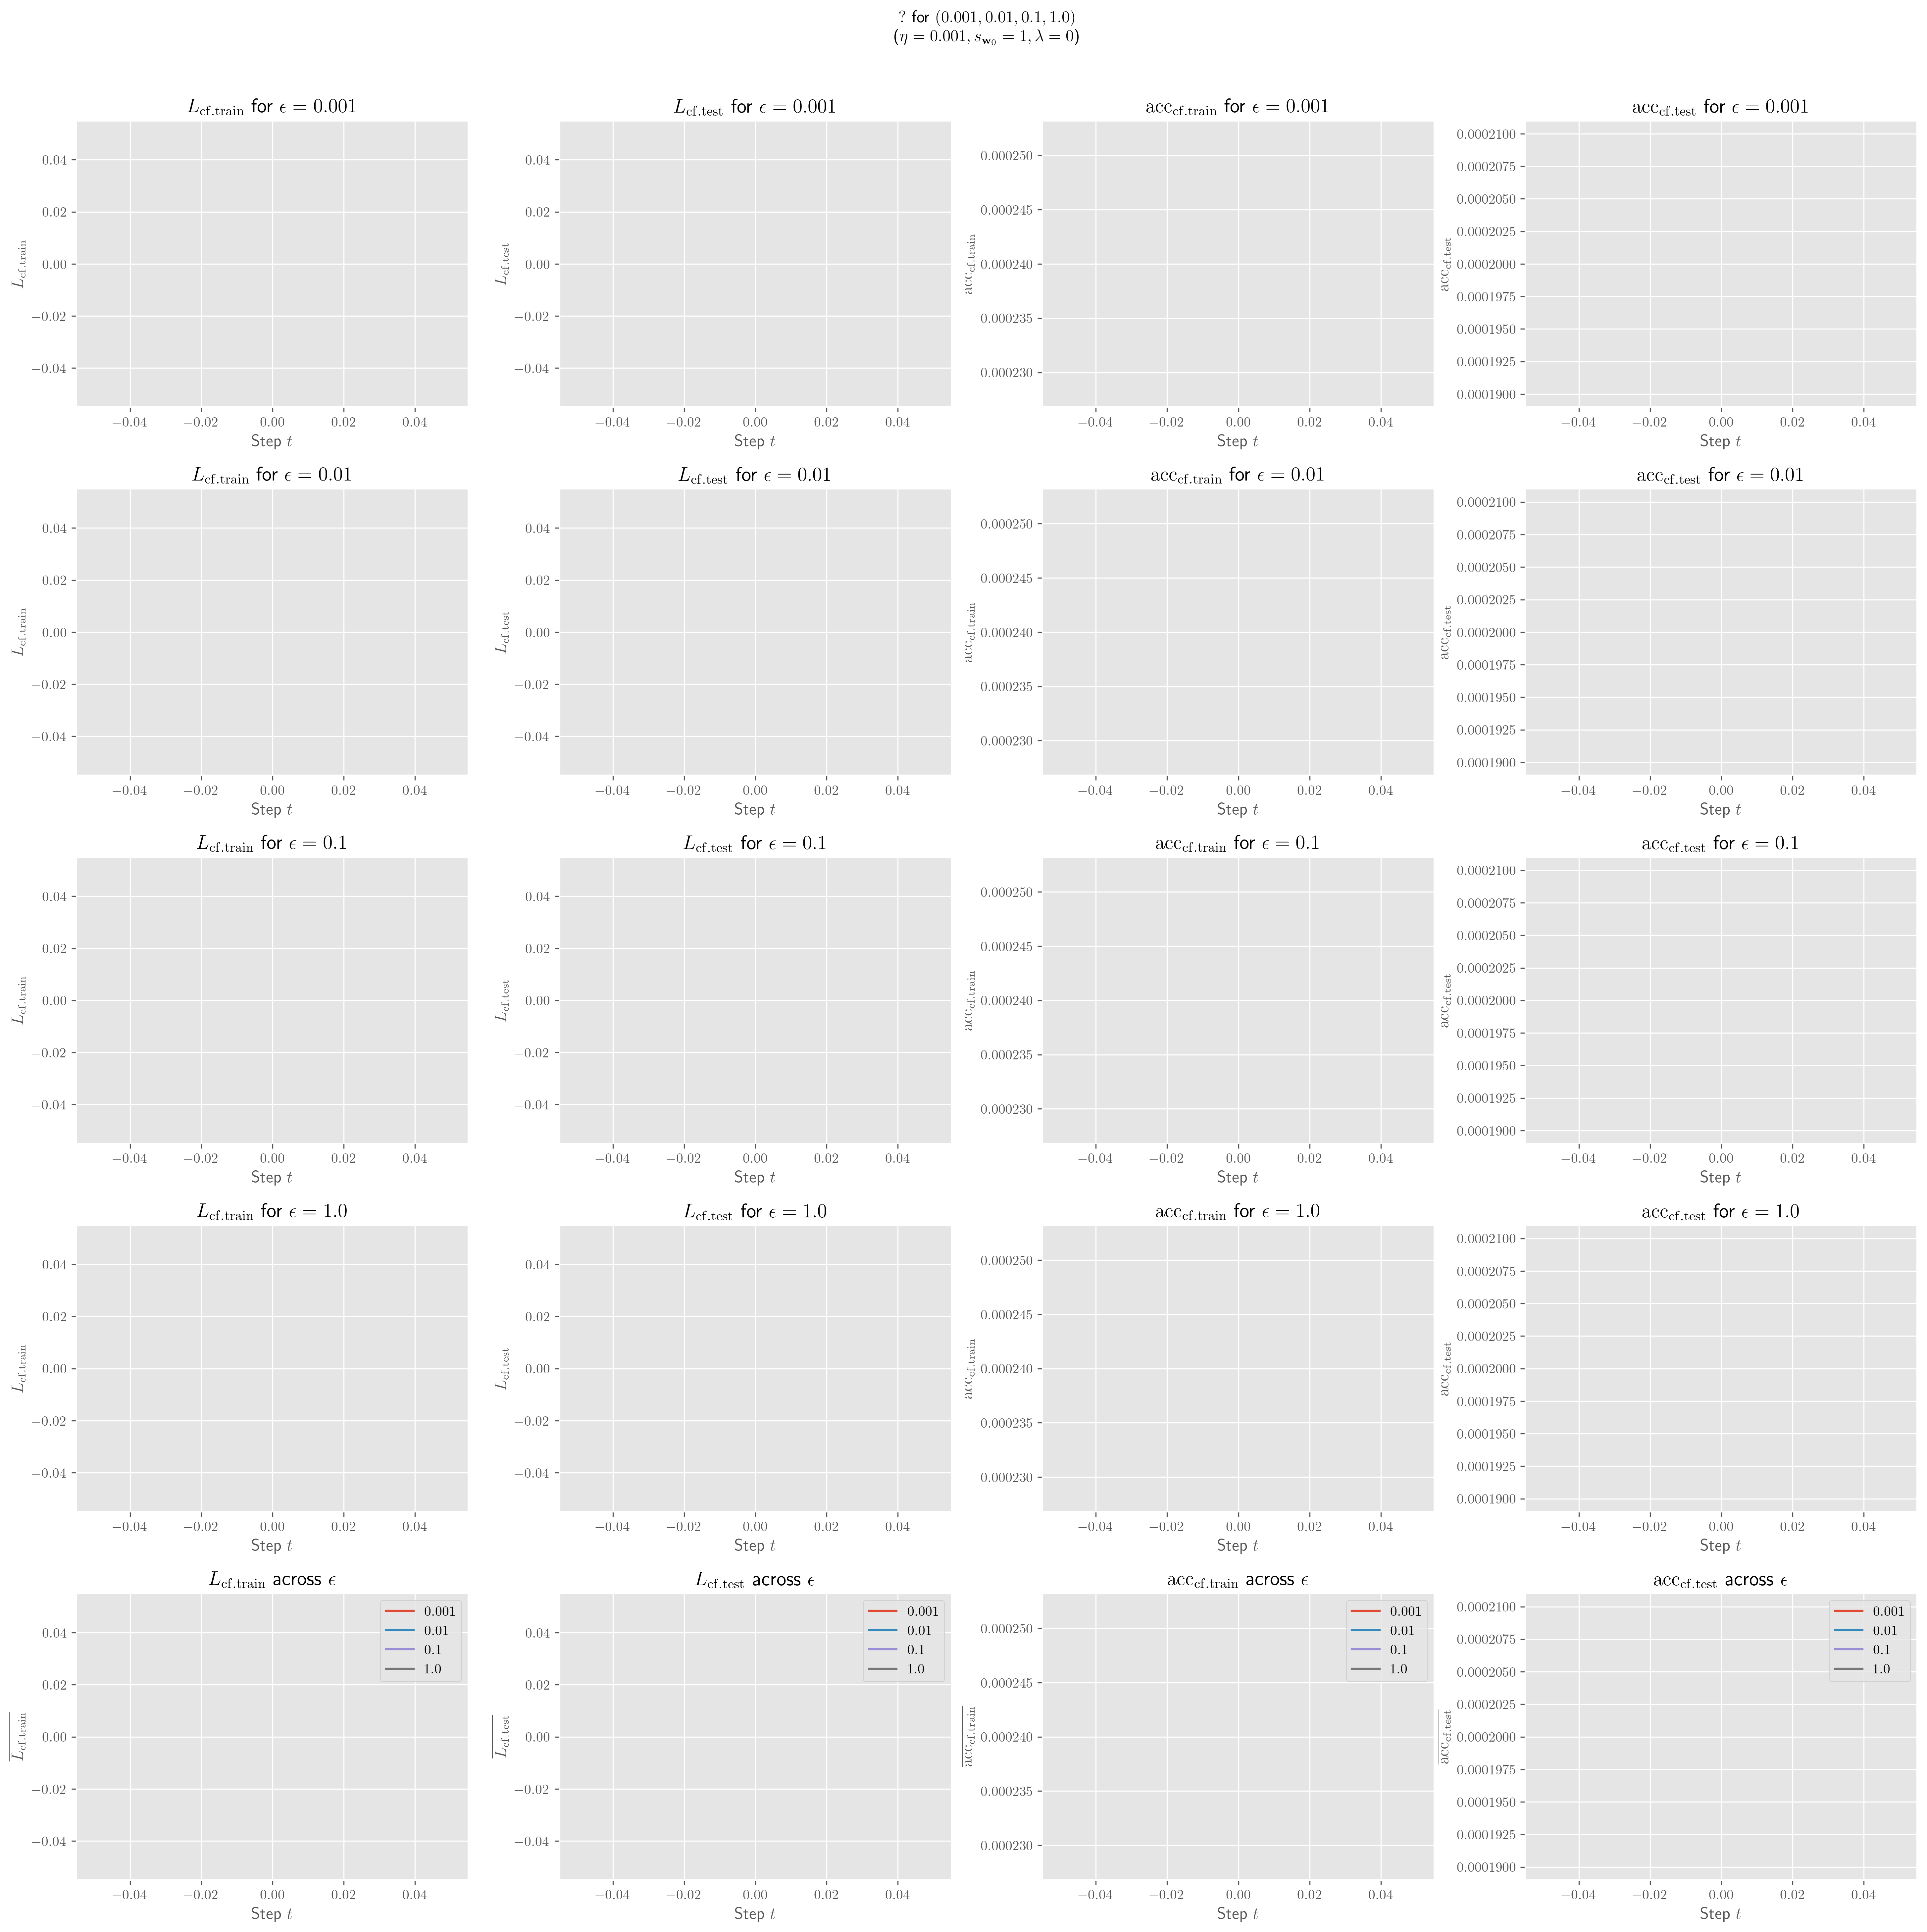

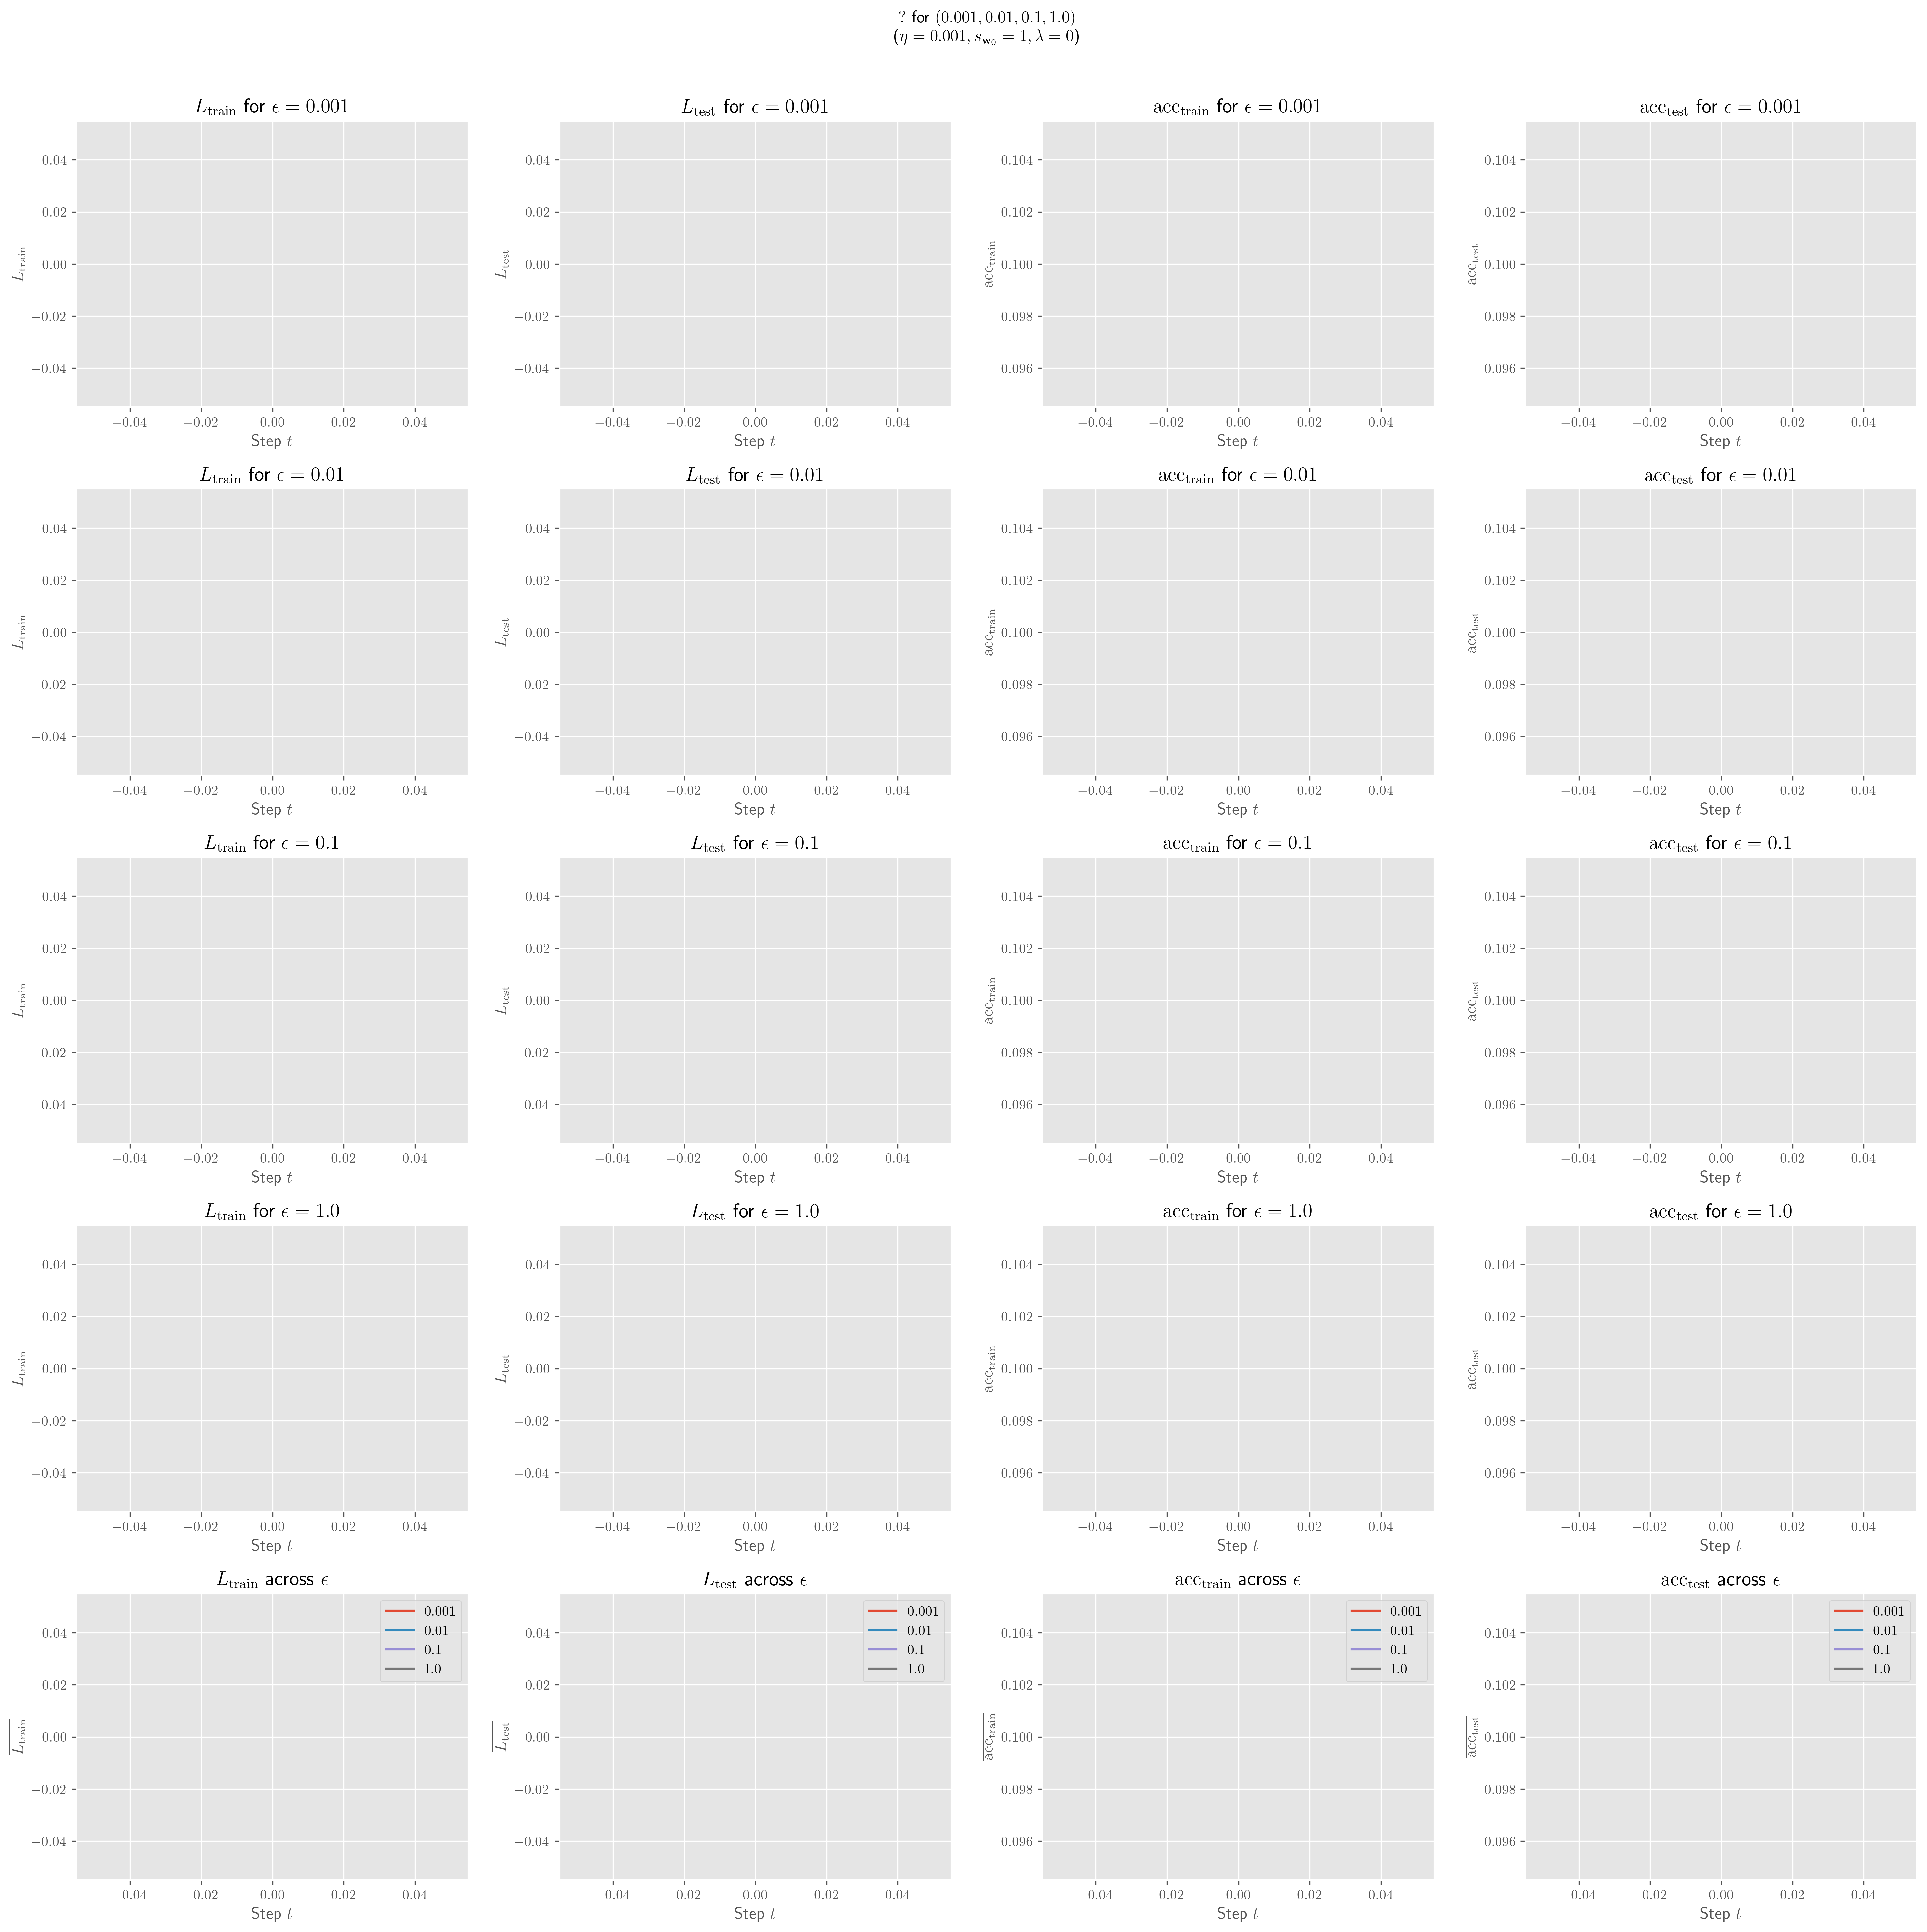

In [2]:
for ensemble in tqdm(make_ensembles(
        [experiments[-1]],
        logging_ivl=100,
        plot_ivl=2000,
        save_ivl=1000,
    ), desc=""):
    ensemble.train(n_epochs=10)